<img src='https://www.commonfloor.com/articles/wp-content/uploads/2012/07/dva1-300x199.jpg' width=500>
<div align="center"><font size="2">Source: Google</font></div>

<p>This is a Playground competition which will give you the opportunity to try different encoding schemes for different algorithms and compare how they perform.</p>

<p> This is the follow up competition to the previous categorical encoding challenge 1</p>

<p> The features are given as below </p> 
    
    
* binary features
* low- and high-cardinality nominal features
* low- and high-cardinality ordinal features
* (potentially) cyclical features

<font color='#000000' size=4>Objective</font><br>

* Exploration and finding interactions
* Build models
* Evaluate models

**Let's start tickling!!**

<font color='#088a5a' size=3>Kindly upvote the kernel if you like it!</font><br>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.display import display, HTML
import pandas_profiling as pp
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
from IPython.display import Markdown
import scipy.stats as ss
import itertools
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from sklearn.metrics import auc
import datetime
from time import time
from catboost import CatBoostClassifier

# Any results you write to the current directory are saved as output.

<font color='#088a5a' size=4>Data glimpse</font><br>

In [3]:
path='../input/cat-in-the-dat-ii/'

train=pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')
submission=pd.read_csv(path+'sample_submission.csv')


In [4]:
display(HTML(f"""
   
        <ul class="list-group">
          <li class="list-group-item disabled" aria-disabled="true"><h4>Shape of Train and Test Dataset</h4></li>
          <li class="list-group-item"><h4>Number of rows in Train dataset is: <span class="label label-primary">{ train.shape[0]:,}</span></h4></li>
          <li class="list-group-item"> <h4>Number of columns Train dataset is <span class="label label-primary">{train.shape[1]}</span></h4></li>
          <li class="list-group-item"><h4>Number of rows in Test dataset is: <span class="label label-success">{ test.shape[0]:,}</span></h4></li>
          <li class="list-group-item"><h4>Number of columns Test dataset is <span class="label label-success">{test.shape[1]}</span></h4></li>
        </ul>
  
    """))

<font color='#0000ff' size=3>Panda's profiling</font><br>

Taking a fraction of data(1%) for checking the over-view of data

In [5]:
sample_profile=train.sample(frac=0.01)

pp.ProfileReport(sample_profile)

<font color='#088a5a' size=4>Data walk through</font><br>

In [6]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Total'] = df.count().values   
    summary['Missing Percentage']=(summary['Missing']/summary['Total'])*100
    summary['Uniques'] = df.nunique().values

    return summary

In [7]:
trainsum = resumetable(train)
trainsum

Dataset Shape: (600000, 25)


,Name,dtypes,Missing,Total,Missing Percentage,Uniques
0,id,int64,0,600000,0.000000,600000
1,bin_0,float64,17894,582106,3.074011,2
2,bin_1,float64,18003,581997,3.093315,2
3,bin_2,float64,17930,582070,3.080386,2
4,bin_3,object,18014,581986,3.095263,2
5,bin_4,object,18047,581953,3.101110,2
6,nom_0,object,18252,581748,3.137441,3
7,nom_1,object,18156,581844,3.120424,6
8,nom_2,object,18035,581965,3.098984,6
9,nom_3,object,18121,581879,3.114221,6


In [8]:
testsum = resumetable(test)
testsum

Dataset Shape: (400000, 24)


,Name,dtypes,Missing,Total,Missing Percentage,Uniques
0,id,int64,0,400000,0.000000,400000
1,bin_0,float64,11901,388099,3.066486,2
2,bin_1,float64,12038,387962,3.102881,2
3,bin_2,float64,11972,388028,3.085344,2
4,bin_3,object,11951,388049,3.079766,2
5,bin_4,object,11951,388049,3.079766,2
6,nom_0,object,12062,387938,3.109260,3
7,nom_1,object,11947,388053,3.078703,6
8,nom_2,object,12179,387821,3.140366,6
9,nom_3,object,12176,387824,3.139568,6


Trivia:

* There seems to be around only 3% of missing values in both training and test data
* Nominal features 5 to 9 has more unique values in both training and test data

<font color='#0000ff' size=3>Target distribution</font><br>

In [9]:
## target distribution ##
cnt_srs=train.target.value_counts()

labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=15),
    width=500,
    height=500,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

Trivia:

* There is a huge imbalance between targets 0 (81.3%) and 1 (18.7%)

In [10]:
bin_features=[i for i in train.columns if i.split('_')[0]=='bin']
ord_features=[i for i in train.columns if i.split('_')[0]=='ord']
nom_features=[i for i in train.columns if i.split('_')[0]=='nom']

cyc_features=[i for i in train.columns if i in ['day','month']]

Thanks to this wonderful [kernel](https://www.kaggle.com/vikassingh1996/handling-categorical-variables-encoding-modeling) for the below charts 

<font color='#0000ff' size=3>Binary variables</font><br>

In [11]:
'''#2.Function for displaying bar lebels in relative scale.'''
def pct_bar_labels():
    font_size = 15
    plt.ylabel('Relative Frequency (%)', fontsize = font_size)
    plt.xticks(rotation = 0, fontsize = font_size)
    plt.yticks([]) 
    
    # Set individual bar lebels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = font_size, color = 'black')
        
'''Display markdown formatted output like bold, italic bold etc.'''

def bold(string):
    display(Markdown(string))

In [12]:
'''Create a function that relative frequency of Target variable by a categorical variable. 
And then plots the relative frequency of target by a categorical variable.'''

def crosstab(cat, cat_target, color):
    '''cat = categorical variable, cat_target = our target categorical variable.'''
    global ax1
    fig_size = (18, 5)
    title_size = 18
    font_size = 15
    
    pct_cat_grouped_by_cat_target = round(pd.crosstab(index = cat, columns = cat_target, normalize = 'index')*100, 2)
       
    # Plot relative frequrncy of Target by a categorical variable
    ax1 = pct_cat_grouped_by_cat_target.plot.bar(color = color, title = 'Percentage Count of target by %s' %cat.name, figsize = fig_size)
    ax1.title.set_size(fontsize = title_size)
    pct_bar_labels()
    plt.xlabel(cat.name, fontsize = font_size)
    plt.show()

**Percentage Count of target by bin_0:**

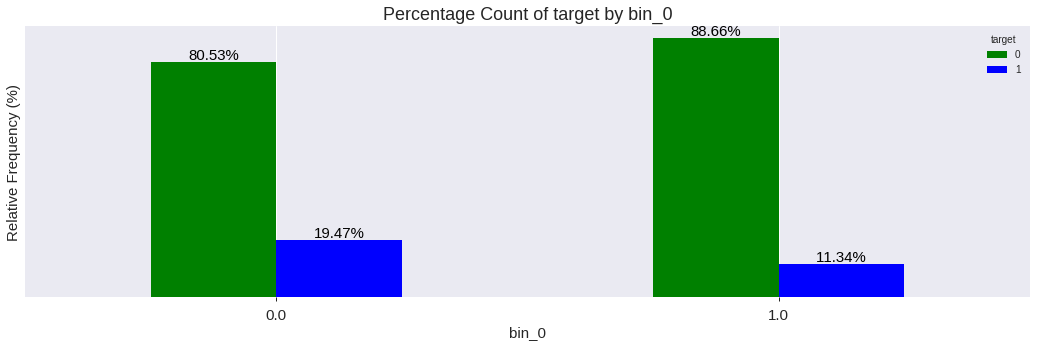

**Percentage Count of target by bin_1:**

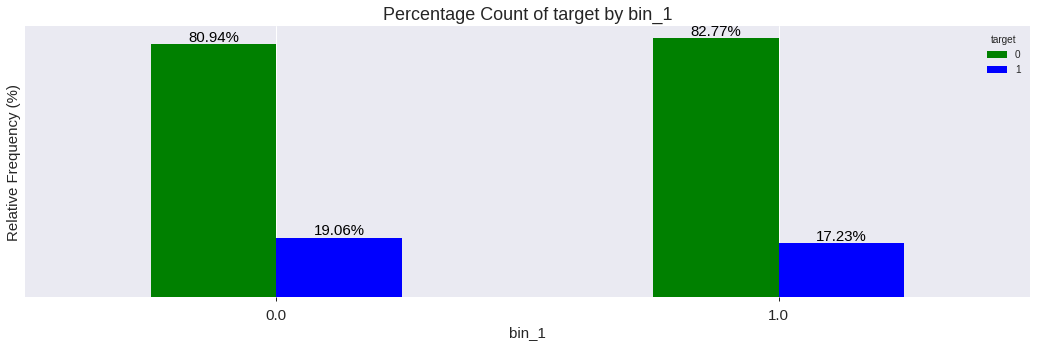

**Percentage Count of target by bin_2:**

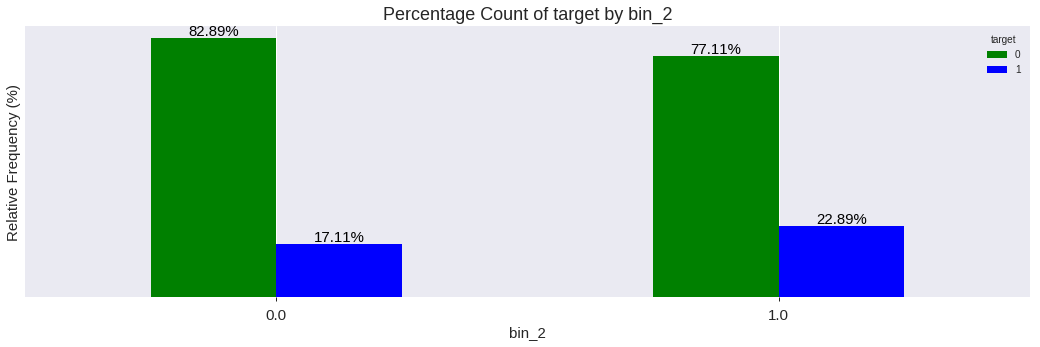

**Percentage Count of target by bin_3:**

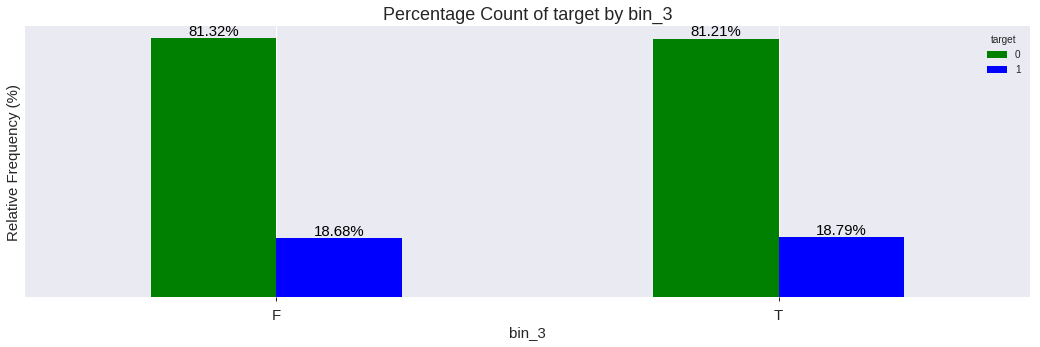

**Percentage Count of target by bin_4:**

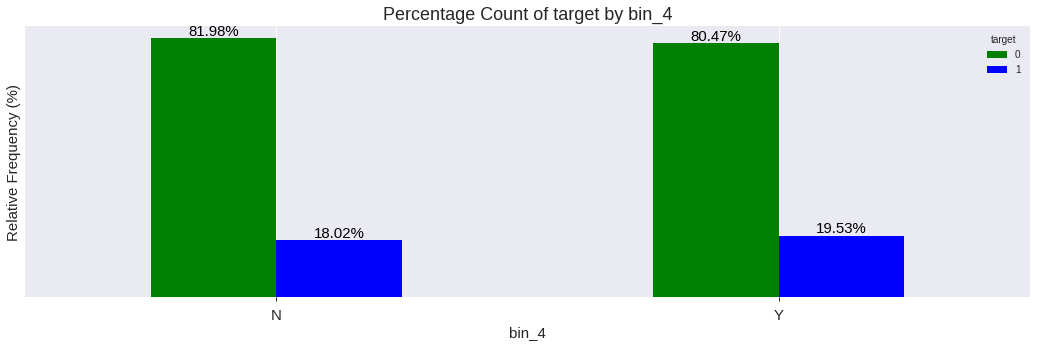

In [13]:
'''Plot the binary variables in relative scale'''

for i,val in enumerate(bin_features):
    bold(f'**Percentage Count of target by {val}:**')
    crosstab(train[val], train.target, color = ['g', 'b'])

<font color='#0000ff' size=3>Ordinal variables</font><br>

**Percentage Count of target by ord_0:**

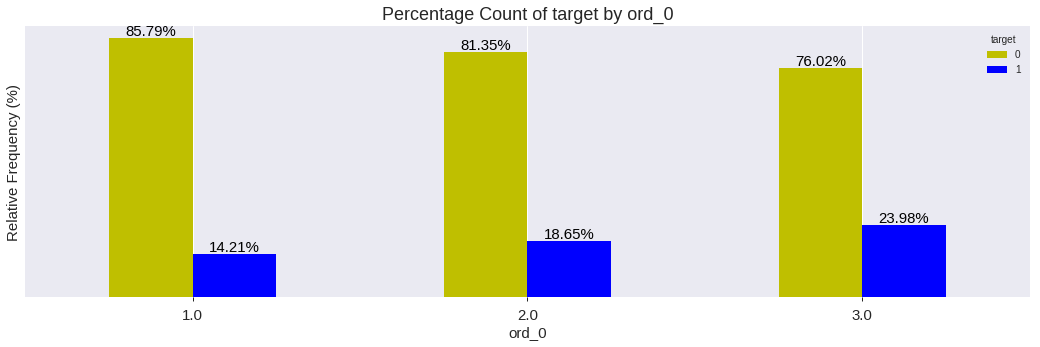

**Percentage Count of target by ord_1:**

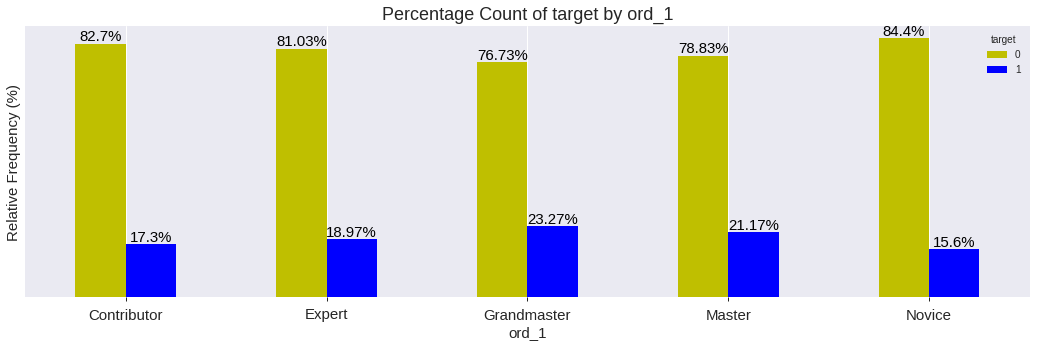

**Percentage Count of target by ord_2:**

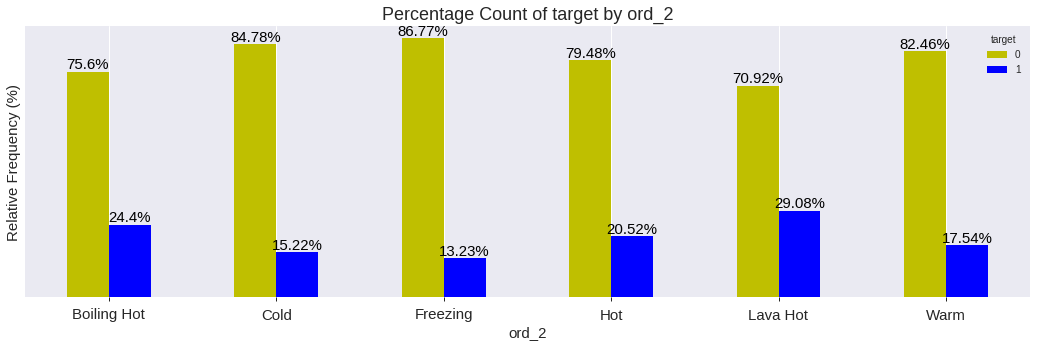

In [14]:
'''Plot the ordinal variables in relative scale'''

for i,val in enumerate(ord_features[:3]):
    bold(f'**Percentage Count of target by {val}:**')
    crosstab(train[val], train.target, color = ['y', 'b'])

<font color='#0000ff' size=3>Nominal variables</font><br>

**Percentage Count of target by nom_0:**

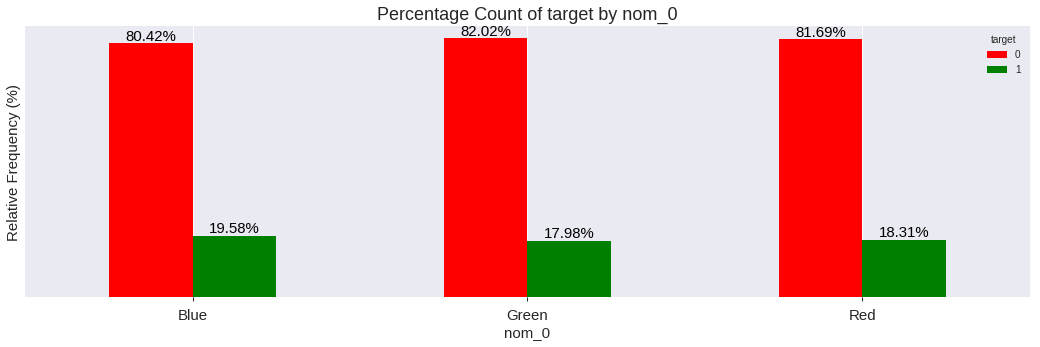

**Percentage Count of target by nom_1:**

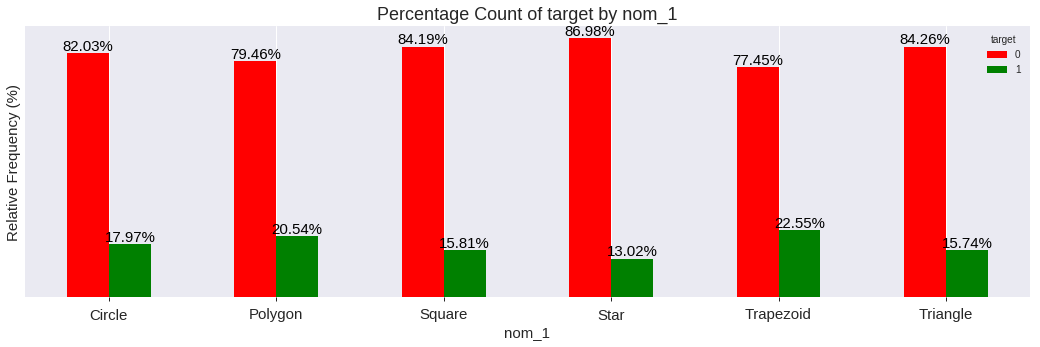

**Percentage Count of target by nom_2:**

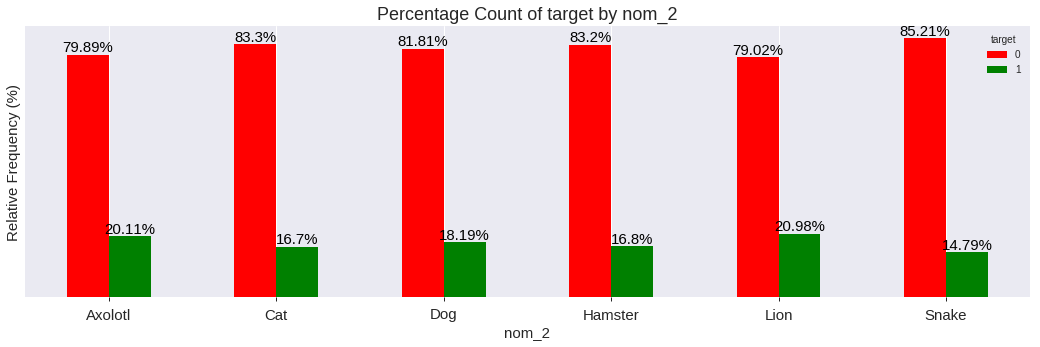

**Percentage Count of target by nom_3:**

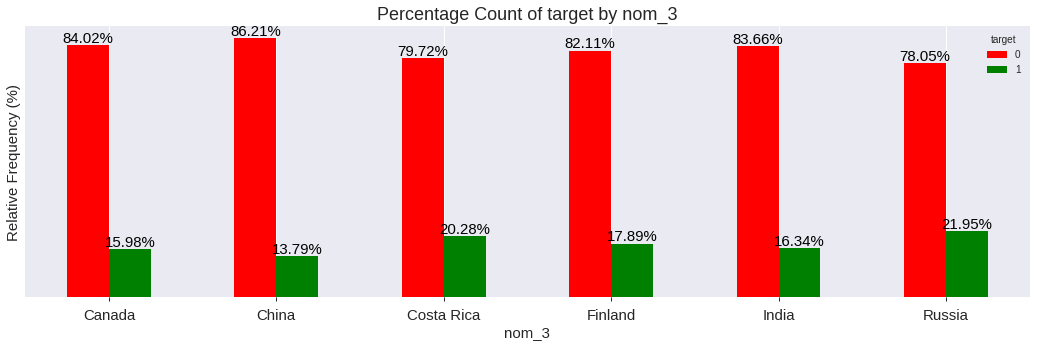

**Percentage Count of target by nom_4:**

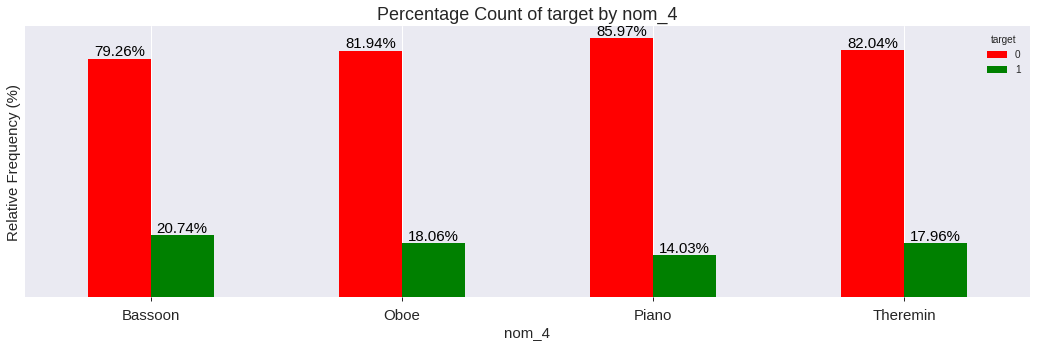

In [15]:
'''Plot the nominal variables in relative scale'''

for i,val in enumerate(nom_features[:5]):
    bold(f'**Percentage Count of target by {val}:**')
    crosstab(train[val], train.target, color = ['r', 'g'])

<font color='#0000ff' size=3>Cyclical variables</font><br>

**Percentage Count of target by day:**

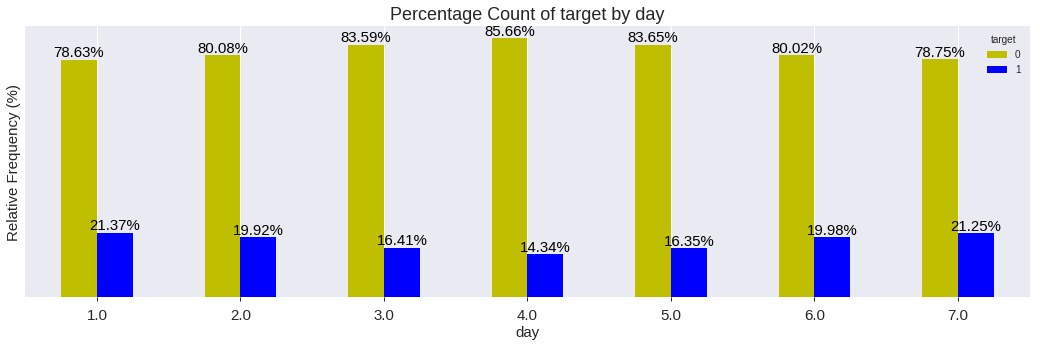

**Percentage Count of target by month:**

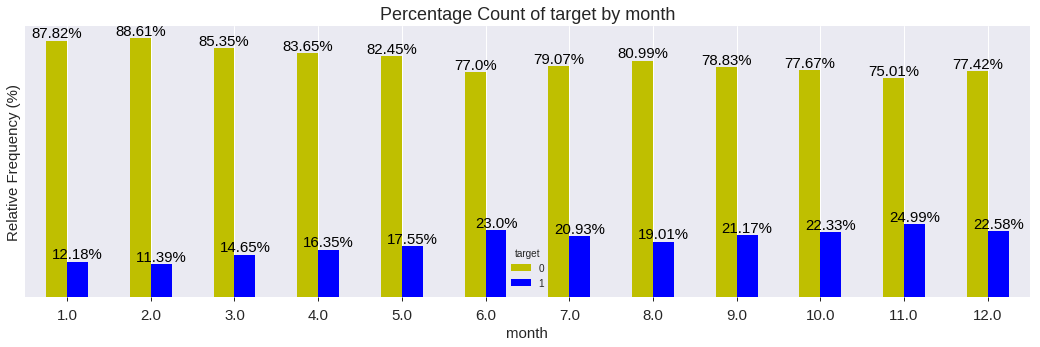

In [16]:
'''Plot the cyclic variables in relative scale'''

for i,val in enumerate(cyc_features):
    bold(f'**Percentage Count of target by {val}:**')
    crosstab(train[val], train.target, color = ['y', 'b'])

Trivia:

* There is a again a huge percentage differnce across all cat variables between targets

<font color='#0000ff' size=3>Interaction between cat variables - Crammer's rule</font><br>

In [17]:
train_copy=train.dropna()

In [18]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

all_feat=bin_features+nom_features+ord_features+cyc_features

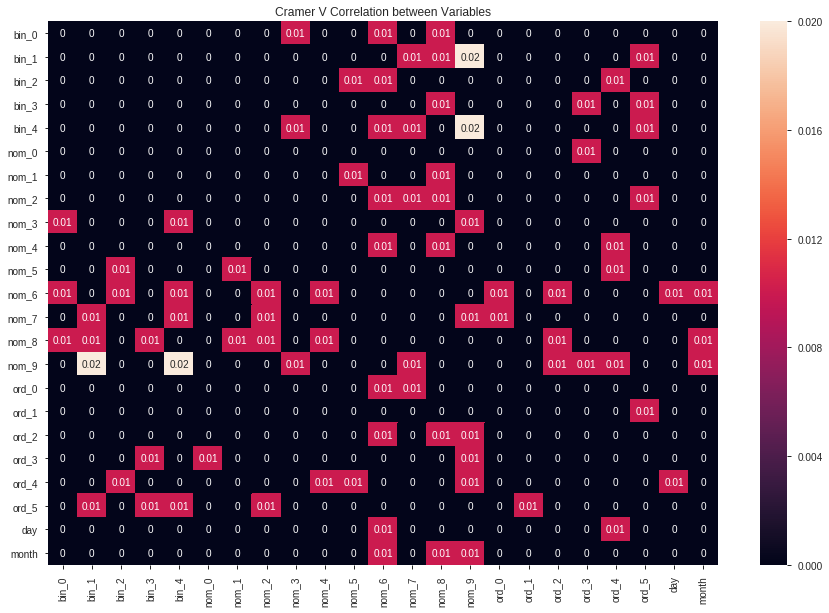

In [19]:
corrM = np.zeros((len(all_feat),len(all_feat)))

for col1, col2 in itertools.combinations(all_feat, 2):
    idx1, idx2 = all_feat.index(col1), all_feat.index(col2)
    corrM[idx1, idx2] = cramers_v(train_copy[col1], train_copy[col2])
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=all_feat, columns=all_feat)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(round(corr,2), annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

del train_copy

Trivia:

* Looks like there is no much of interactions between variables.

<font color='#088a5a' size=4>Data encoding and cleaning</font><br>

In [21]:
# CREDITS : https://www.kaggle.com/caesarlupum/2020-20-lines-target-encoding

def encoding(train, test, smooth):
    print('Target encoding...')
    train.sort_index(inplace=True)
    target = train['target']
    test_id = test['id']
    train.drop(['target', 'id'], axis=1, inplace=True)
    test.drop('id', axis=1, inplace=True)
    cat_feat_to_encode = bin_features+nom_features+ord_features+cyc_features
    smoothing=smooth
    oof = pd.DataFrame([])
    
    for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2020, shuffle=True).split(train, target):
        ce_target_encoder = ce.TargetEncoder(cols = cat_feat_to_encode, smoothing=smoothing)
        ce_target_encoder.fit(train.iloc[tr_idx, :], target.iloc[tr_idx])
        oof = oof.append(ce_target_encoder.transform(train.iloc[oof_idx, :]), ignore_index=False)
        
    ce_target_encoder = ce.TargetEncoder(cols = cat_feat_to_encode, smoothing=smoothing)
    ce_target_encoder.fit(train, target)
    train = oof.sort_index()
    test = ce_target_encoder.transform(test)
    features = list(train)
    print('Target encoding done!')
    return train, test, test_id, features, target


In [22]:
# Encoding
train_encode, test_encode, test_id, features, target = encoding(train, test, 0.3)

Target encoding...
Target encoding done!


<font color='#088a5a' size=4>Modelling and inference- MEOW</font><br>

In [23]:
train_encode=pd.concat([train_encode,target],axis=1,ignore_index=True)
train_encode.columns=list(train.columns)+['target']

In [24]:
X, y = train_encode[all_feat], train_encode['target']

In [25]:
def make_classifier():
    clf = CatBoostClassifier(
                               loss_function='CrossEntropy',
                               eval_metric="AUC",
                               task_type="CPU",
                               learning_rate=0.05,
                               n_estimators =5000,
                               early_stopping_rounds=10,
                               random_seed=2019
                              )
        
    return clf

oof = np.zeros(len(X))

In [26]:
preds = np.zeros(len(test_encode))
oof = np.zeros(len(X))
NFOLDS = 15

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)


training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print(f'Training on fold {fold+1}')
    clf = make_classifier()
    clf.fit(X.loc[trn_idx, all_feat], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_feat], y.loc[test_idx]),
                          use_best_model=True, verbose=500)
    
    preds += clf.predict_proba(test_encode)[:,1]/NFOLDS
    oof[test_idx] = clf.predict_proba(X.loc[test_idx, all_feat])[:,1]
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('OOF',metrics.roc_auc_score(y, oof))
print('-' * 30)

Training on fold 1
0:	test: 0.6970304	best: 0.6970304 (0)	total: 228ms	remaining: 18m 57s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7870228297
bestIteration = 374

Shrink model to first 375 iterations.
Fold 1 finished in 0:00:58.602700
Training on fold 2
0:	test: 0.6980788	best: 0.6980788 (0)	total: 150ms	remaining: 12m 32s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7893362193
bestIteration = 359

Shrink model to first 360 iterations.
Fold 2 finished in 0:00:56.094630
Training on fold 3
0:	test: 0.6957837	best: 0.6957837 (0)	total: 148ms	remaining: 12m 21s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7857406339
bestIteration = 408

Shrink model to first 409 iterations.
Fold 3 finished in 0:01:02.508151
Training on fold 4
0:	test: 0.6958976	best: 0.6958976 (0)	total: 147ms	remaining: 12m 14s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.786170335
bestIteration = 473

Shrink model to first 474

In [27]:
submission['target'] = preds
submission.to_csv('submission_meow.csv', index=None)
submission.head()

,id,target
0,600000,0.045658
1,600001,0.086600
2,600002,0.050618
3,600003,0.041654
4,600004,0.047507


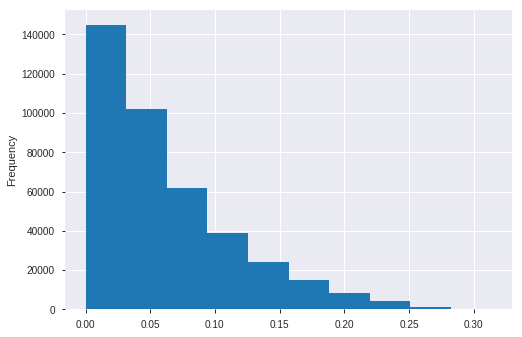

In [28]:
submission['target'].plot(kind='hist')

<font color='#088a5a' size=4>Stay tuned!!</font><br>

In [29]:
!ls

__notebook_source__.ipynb  catboost_info  submission_meow.csv


In [30]:
# !kaggle competitions submit -c cat-in-the-dat-ii -f submission_meow.csv -m "2020.01.10 submission_meow.csv"

/bin/sh: 1: kaggle: not found
